<a href="https://colab.research.google.com/github/aaaaaamah99/Computer_Vision/blob/main/Another_copy_of_Classification_of_Covid_19_Pneumonia_on_CT_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'covid19normalpneumonia-ct-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F832492%2F1421897%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T025629Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1ac0c344bdd50251395ffe10f441023619dd85c052d8a650d6ea91a79499d93abc8054d8cd44f30b9754ff10c9046695ee538e005b1be69790161fbbb91c8e761cb4225ffb64523b6c7e16203b886d39e730918289b698c40d4360f3663d2221a37473716a37809051aaaf4f65c8bb066f141fc5709222ef9deaaca000636cc303d263ff106b39b48e3bbbcb7e49d144a46634dea59088d4b834ba8197b5d3bc8a18c3b5f00da9396b9b11621c7d9f6eaef1e8c5d876e1b4d579e0e54b169dc634510e2b0a80dffb15780501ad5e5e64669149416e0759592ba0c0ca624894bebf07f177b9207f7dddad94b3940db785b14aec7986a034795e7d24e9e953ef73'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 981279236 bytes downloaded
Downloaded and uncompressed: covid19normalpneumonia-ct-images
Data source import complete.


# Importing essential libraries

In [ ]:
!pip install --upgrade tensorflow keras


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os
import shutil
import random
import cv2
import zipfile
import matplotlib.cm as cm

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import Progbar
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Updated import path
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPool2D, AveragePooling2D, Flatten, Input, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model  # Correct import path for plot_model
from tensorflow.keras.utils import get_custom_objects
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Deleting directories in order to recreate

In [ ]:
try:
    shutil.rmtree("./train")
    shutil.rmtree("./test")
    shutil.rmtree("./val")

except OSError as e:
    print("Directories never existed")

Directories never existed


# Creating data directories and splitting into Train, Test, Valid

In [ ]:
path = "../input/covid19normalpneumonia-ct-images"
classesPath = ['COVID2_CT', 'Normal_CT', 'pneumonia_CT']

np.random.seed(seed = 90)

val_ratio = 0.1
test_ratio = 0.1
seed = 90

for cls in classesPath:
    os.makedirs('./train/' + cls)
    os.makedirs('./val/' + cls)
    os.makedirs('./test/' + cls)

    src = path + "/" + cls

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                               int(len(allFileNames) * (1 - test_ratio))])

    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]

    print('Total ', str(cls), len(allFileNames))
    print('Training', len(train_FileNames))
    print('Validation', len(val_FileNames))
    print('Testing', len(test_FileNames))
    print("\n")

    for name in train_FileNames:
        shutil.copy(name, './train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, './val/' + cls)

    for name in test_FileNames:
        shutil.copy(name, './test/' + cls)

FileExistsError: [Errno 17] File exists: './train/COVID2_CT'

# Creating image data generator for training and testing

In [ ]:
path_train = "./train"
path_val = "./val"
path_test = "./test"

batch_size = 32
batch_test_size = 16
seed = 90
interpolation = "bicubic"
target_size = (256, 256)
epochs = 50

train_data_gen = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,  # Geser gambar secara horizontal sebesar 10% lebar gambar
                                    height_shift_range=0.1, # Geser gambar secara vertikal sebesar 10% tinggi gambar
                                    shear_range=0.2,        # Miringkan gambar dengan rentang 20 derajat
                                    zoom_range=0.2,         # Perbesar atau perkecil gambar hingga 20%
                                    horizontal_flip=True,  # Putar gambar secara horizontal secara acak
                                    fill_mode='nearest')    # Isi piksel yang kosong dengan nilai terdekat)


test_data_gen = ImageDataGenerator()

ds_train = train_data_gen.flow_from_directory(directory = path_train,
                                              color_mode = "rgb",
                                              batch_size = batch_size,
                                              class_mode='categorical',
                                              target_size = target_size,
                                              shuffle = True,
                                              interpolation = interpolation,
                                              seed = seed)

ds_val = test_data_gen.flow_from_directory(directory = path_val,
                                           color_mode = "rgb",
                                           batch_size = batch_size,
                                           class_mode='categorical',
                                           target_size = target_size,
                                           shuffle = True,
                                           interpolation = interpolation,
                                           seed = seed)

ds_test = test_data_gen.flow_from_directory(directory = path_test,
                                            color_mode = "rgb",
                                            batch_size = batch_test_size,
                                            target_size = target_size,
                                            class_mode='categorical',
                                            shuffle = False,
                                            interpolation = interpolation,
                                            seed = seed)

Found 6035 images belonging to 3 classes.
Found 754 images belonging to 3 classes.
Found 755 images belonging to 3 classes.


# Augmentasi

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inisialisasi objek ImageDataGenerator untuk augmentasi data
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotasi gambar dalam rentang 20 derajat
    width_shift_range=0.1,  # Geser gambar secara horizontal sebesar 10% lebar gambar
    height_shift_range=0.1, # Geser gambar secara vertikal sebesar 10% tinggi gambar
    shear_range=0.2,        # Miringkan gambar dengan rentang 20 derajat
    zoom_range=0.2,         # Perbesar atau perkecil gambar hingga 20%
    horizontal_flip=True,  # Putar gambar secara horizontal secara acak
    fill_mode='nearest'    # Isi piksel yang kosong dengan nilai terdekat
)

# Menggunakan objek ImageDataGenerator untuk melakukan augmentasi data pada gambar
# Contoh: mengambil satu gambar dari direktori 'data/train' dan membuat batch augmentasi
# data yang tak terbatas dengan batch size 1
train_generator = datagen.flow_from_directory(
    '/content/train',
    target_size=(256, 256),  # Ukuran gambar yang diharapkan
    batch_size=32,           # Ukuran batch
    class_mode='categorical' # Mode kelas untuk masalah klasifikasi
)

# Penggunaan contoh batch augmentasi data
for images, labels in train_generator:
    # Lakukan apa pun yang diperlukan dengan batch gambar yang telah di-augmentasi
    # Misalnya, latih model menggunakan batch ini
    pass


Found 6035 images belonging to 3 classes.


# **Tanpa Earlystop**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Nadam

# Define the input shape based on your image dimensions
input_shape = (256, 256, 3)  # Replace height, width, and channels with actual values
# Definisikan model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(3))  # Menggunakan tiga unit karena ada tiga kelas
model.add(Activation('softmax'))  # Aktivasi softmax untuk klasifikasi multikelas


model.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 254, 254, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 252, 252, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 252, 252, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 252, 252, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 124, 124, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 124, 124, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 124, 124, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 122, 122, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 122, 122, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 59, 59, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 59, 59, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 57, 57, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 57, 57, 128)         │             5

 Total params: 20,054,563 (76.50 MB)

 Trainable params: 20,051,619 (76.49 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Nadam

# Tentukan lokasi penyimpanan model terbaik dengan ekstensi .keras
filepath = "best_model_3.keras"

# Definisikan ModelCheckpoint untuk menyimpan model terbaik berdasarkan validasi accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

# List semua callbacks yang akan digunakan (tanpa EarlyStopping)
callbacks_list = [checkpoint]

# Compile model dengan optimizer dan loss function yang sesuai
model.compile(optimizer=Nadam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Tentukan jumlah epoch yang diinginkan
epochs = 50

# Latih model dengan generator data pelatihan dan validasi, sambil menggunakan callbacks
history = model.fit(ds_train, epochs=epochs, validation_data=ds_val, shuffle=True, callbacks=callbacks_list)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 195s 847ms/step - accuracy: 0.3869 - loss: 1.3235 - val_accuracy: 0.5318 - val_loss: 0.9834
Epoch 2/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 160s 740ms/step - accuracy: 0.6435 - loss: 0.8004 - val_accuracy: 0.8024 - val_loss: 0.4624
Epoch 3/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 144s 733ms/step - accuracy: 0.6978 - loss: 0.6570 - val_accuracy: 0.7958 - val_loss: 0.4381
Epoch 4/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 206s 757ms/step - accuracy: 0.7561 - loss: 0.5598 - val_accuracy: 0.8607 - val_loss: 0.3276
Epoch 5/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 144s 739ms/step - accuracy: 0.7746 - loss: 0.5037 - val_accuracy: 0.8302 - val_loss: 0.3576
Epoch 6/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 201s 735ms/step - accuracy: 0.7933 - loss: 0.4520 - val_accuracy: 0.8568 - val_loss: 0.3072
Epoch 7/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 142s 726ms/step - accuracy: 0.8193 - loss: 0.4121 - val_accuracy: 0.8103 - val_loss: 0.3796
Epoch 8/50
189/189 ━━━━━━━━━━━━━━━━━━━━ 145s 737ms/step - accuracy: 0.8273 - loss: 0.39

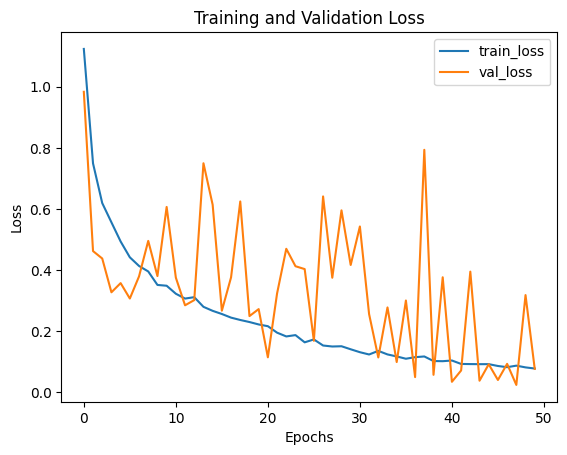

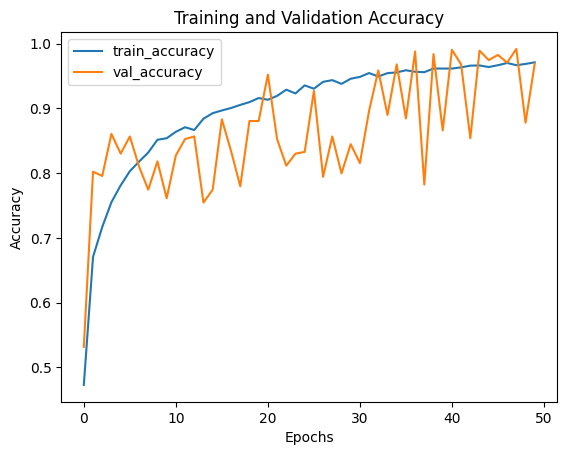

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluasi model menggunakan data uji
test_loss, test_accuracy = model.evaluate(ds_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.9535 - loss: 0.1324
Test Loss: 0.09383034706115723
Test Accuracy: 0.9655629396438599


# 1. Xception Model

In [ ]:
model_Xception = Xception(weights='imagenet',include_top=False)
full_name = "Xception_Model"

x = model_Xception.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3,'softmax', name = "Output")(x)

model_Xception = Model(inputs=model_Xception.input, outputs = y_hat)

if not os.path.exists("./Weights"):
    os.makedirs('./Weights')
if not os.path.exists("./Weights/Xception"):
    os.makedirs('./Weights/Xception')

filepath = "./Weights/Xception/%s-Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name

plot_model(model_Xception, show_shapes = True, show_layer_names = True, to_file = "Xception.png")

In [ ]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [earlystop, checkpoint]
model_Xception.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

historyXception = model_Xception.fit(ds_train, epochs=epochs,validation_data=ds_val,shuffle=True,callbacks=callbacks_list)

In [ ]:
plt.plot(historyXception.history['accuracy'])
plt.plot(historyXception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(historyXception.history['loss'])
plt.plot(historyXception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model_Xception.load_weights("./Weights/Xception/Xception_Model-Final-04-0.9947.hdf5")
# resultsXception = model_Xception.evaluate(ds_test)

# 2. DenseNet121 Model

In [ ]:
model_DenseNet = DenseNet121(weights='imagenet',include_top=False)
full_name = "DenseNet_Model"

x = model_DenseNet.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3,'softmax', name = "Output")(x)

model_DenseNet = Model(inputs=model_DenseNet.input, outputs = y_hat)

if not os.path.exists("./Weights"):
    os.makedirs('./Weights')
if not os.path.exists("./Weights/DenseNet"):
    os.makedirs('./Weights/DenseNet')

filepath = "./Weights/DenseNet/%s-Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name

plot_model(model_DenseNet, show_shapes = True, show_layer_names = True, to_file = "DenseNet.png")

In [ ]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [earlystop, checkpoint]
model_DenseNet.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

historyDenseNet = model_DenseNet.fit(ds_train, epochs=epochs,validation_data=ds_val,shuffle=True,callbacks=callbacks_list)

In [ ]:
plt.plot(historyDenseNet.history['accuracy'])
plt.plot(historyDenseNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(historyDenseNet.history['loss'])
plt.plot(historyDenseNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model_DenseNet.load_weights("./Weights/DenseNet/DenseNet_Model-Final-10-1.0000.hdf5")
# resultsDenseNet = model_DenseNet.evaluate(ds_test)

# 3. ResNet50V2

In [ ]:
model_ResNet = ResNet50V2(weights='imagenet',include_top=False)
full_name = "ResNet_Model"

x = model_ResNet.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3,'softmax', name = "Output")(x)

model_ResNet = Model(inputs=model_ResNet.input, outputs = y_hat)

if not os.path.exists("./Weights"):
    os.makedirs('./Weights')
if not os.path.exists("./Weights/ResNet"):
    os.makedirs('./Weights/ResNet')

filepath = "./Weights/ResNet/%s-Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name

plot_model(model_ResNet, show_shapes = True, show_layer_names = True, to_file = "ResNet.png")

In [ ]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [earlystop, checkpoint]
model_ResNet.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

historyResNet = model_ResNet.fit(ds_train, epochs=epochs,validation_data=ds_val,shuffle=True,callbacks=callbacks_list)

In [ ]:
plt.plot(historyResNet.history['accuracy'])
plt.plot(historyResNet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(historyResNet.history['loss'])
plt.plot(historyResNet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model_ResNet.load_weights(filepath)
# resultsResnet = model_ResNet.evaluate(ds_test)

# 4. InceptionV3

In [ ]:
model_Inception = InceptionV3(weights='imagenet',include_top=False)
full_name = "Inception_Model"

x = model_Inception.output
x = GlobalAveragePooling2D(name = "GlobalAveragePooling_1")(x)

y_hat = Dense(3,'softmax', name = "Output")(x)

model_Inception = Model(inputs=model_Inception.input, outputs = y_hat)

if not os.path.exists("./Weights"):
    os.makedirs('./Weights')
if not os.path.exists("./Weights/Inception"):
    os.makedirs('./Weights/Inception')

filepath = "./Weights/Inception/%s-Final-{epoch:02d}-{val_accuracy:.4f}.hdf5"%full_name

plot_model(model_Inception, show_shapes = True, show_layer_names = True, to_file = "Inception.png")

In [ ]:
earlystop = EarlyStopping(patience=5)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max') #creating checkpoint to save the best validation accuracy
callbacks_list = [earlystop, checkpoint]
model_Inception.compile(optimizer=Nadam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

historyInception = model_Inception.fit(ds_train, epochs=epochs,validation_data=ds_val,shuffle=True,callbacks=callbacks_list)

In [ ]:
plt.plot(historyInception.history['accuracy'])
plt.plot(historyInception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(historyInception.history['loss'])
plt.plot(historyInception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model_Inception.load_weights(filepath)
# resultsInception = model_Inception.evaluate(ds_test)